In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback
import matplotlib.image as mpimg
import warnings
import keras.backend as K
%matplotlib inline
warnings.filterwarnings('ignore')

## Chargement des données

In [38]:
# Get images
imWidth = 224
nbImages = 100
y = []
i = 0
with open("coloredImages.txt") as f:    
    for filename in tqdm(f.readlines()[:nbImages]):
        filename = filename.rstrip()
        filename += ".jpg"
        img = cv2.resize(
            mpimg.imread('data/images/'+filename),
            dsize=(imWidth, imWidth),
            interpolation=cv2.INTER_CUBIC
        )
        y.append(img)
y = np.array(y)
print(y.shape)

(100, 224, 224, 3)


## Transformation en nuances de gris

In [39]:
# Transform img to Grayscale
X = []
for img in tqdm(y):
    X.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
X = np.array(X)
print(X.shape)

(100, 224, 224)


## Visualisation des images

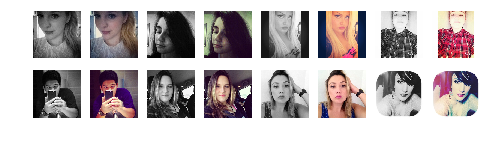

In [40]:
columns = 8
rows = 2
fig=plt.figure(figsize=(columns, rows))
for i in range(1, columns*rows +1,2):
    fig.add_subplot(rows, columns, i)
    plt.imshow(X[i-1], cmap='gray')
    plt.axis('off')
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(y[i-1])
    plt.axis('off')
plt.show()

## Normalisation des Images
Transformer les valeurs des pixels de 0-255 à 0-1

In [41]:
X_reshaped = X.reshape(X.shape[0],imWidth,imWidth,1)
"""
X_scaled = X_reshaped / 255
y_scaled = y / 255
print(np.max(X_scaled))
print(np.max(y_scaled))
print(X_scaled.shape)
"""
X_reshaped.shape

(100, 224, 224, 1)

In [44]:
from keras.layers import Dense, Dropout, Flatten, Reshape, Average, Lambda
from keras.layers import Input, BatchNormalization, Activation, Concatenate, Add
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback

## Premier modèle
Type simple convolutions de même taille

In [57]:
model = Sequential()
model.add(Conv2D(3, kernel_size=3, padding="same", input_shape=X_reshaped.shape[1:], activation="relu"))
model.add(Conv2D(16, kernel_size=3, padding="same", activation="relu"))
#model.add(Conv2D(32, kernel_size=3, padding="same", activation="relu"))
#model.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(32, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(16, kernel_size=3, padding="same", activation="relu"))
model.add(Conv2D(3, kernel_size=3, padding="same", activation="relu"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 224, 224, 3)       30        
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 224, 224, 32)      4640      
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 224, 224, 16)      4624      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 224, 224, 3)       435       
Total params: 10,177
Trainable params: 10,177
Non-trainable params: 0
_________________________________________________________________


In [58]:
model.compile(
    optimizer='adam',
    loss='mse'
)

In [67]:
from IPython.core.display import HTML
from keras_tqdm import TQDMNotebookCallback

display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

history = model.fit(
    X_scaled,
    y_scaled,
    epochs=100,
    batch_size=10, 
    verbose=0,
    validation_split=0.2,
    shuffle=True,
    callbacks=[
        TQDMNotebookCallback()
    ]
)

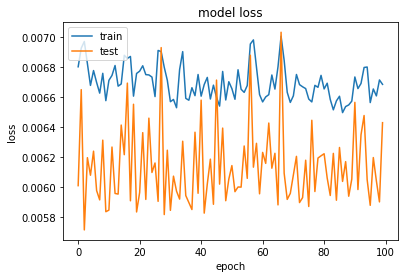

In [68]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

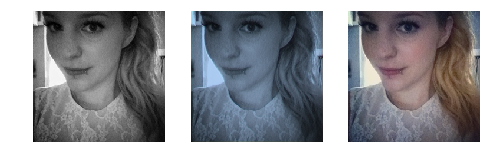

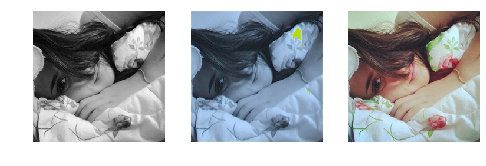

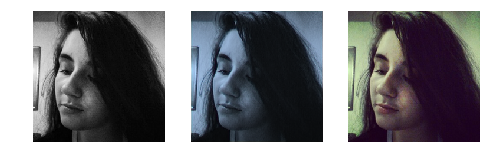

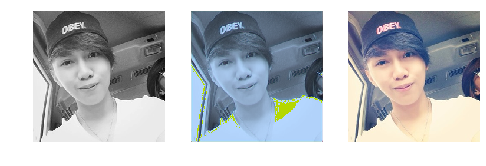

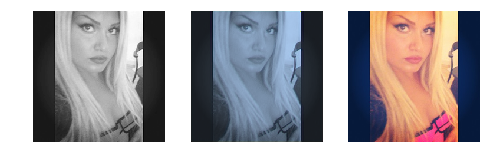

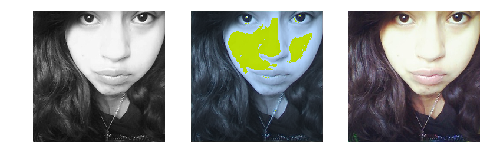

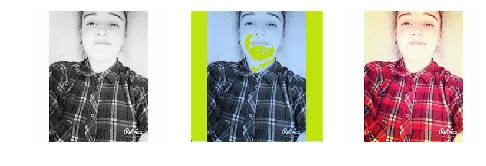

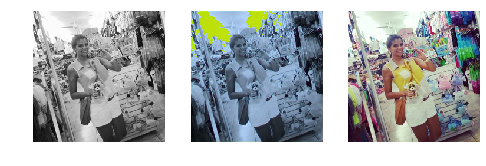

In [69]:
for id in range(8):
    fig = plt.figure(figsize=(8, 4))
    fig.add_subplot(1, 3, 1)
    plt.imshow(X[id], cmap='gray')
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(np.uint8(model.predict(X_reshaped[id:id+1])[0]))
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(np.uint8(y[id]))
    plt.axis('off')
    plt.show()

In [55]:
model.save('coloRayzorSimple.h5')

## Deuxième modèle
Type Autoencoder

In [30]:
model = Sequential()
model.add(Conv2D(3, kernel_size=3, padding="same", input_shape=X_scaled.shape[1:], activation="sigmoid"))
model.add(Conv2D(16, kernel_size=3, padding="same", activation="sigmoid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model.add(Conv2D(32, kernel_size=3, padding="same", activation="sigmoid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model.add(Conv2D(64, kernel_size=3, padding="same", activation="sigmoid"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(32, kernel_size=3, padding="same", activation="sigmoid"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(16, kernel_size=3, padding="same", activation="sigmoid"))
model.add(Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 224, 224, 3)       30        
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 112, 112, 64)      0         
__________

In [31]:
model.compile(
    optimizer='adam',
    loss='mse'
)

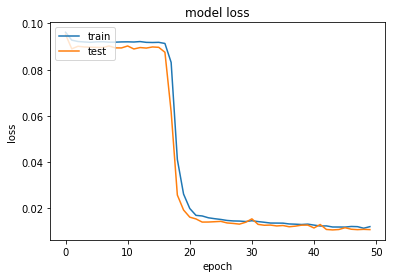

In [32]:
from IPython.core.display import HTML
from keras_tqdm import TQDMNotebookCallback

display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

history = model.fit(
    X_scaled,
    y_scaled,
    epochs=50,
    batch_size=5, 
    verbose=0,
    validation_split=0.2,
    shuffle=True,
    callbacks=[
        TQDMNotebookCallback()
    ]
)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

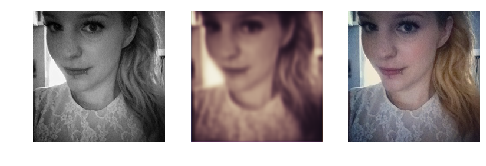

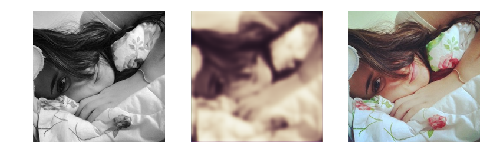

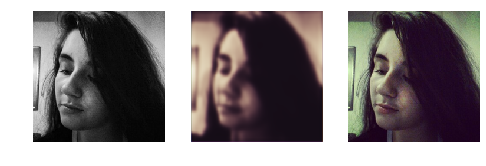

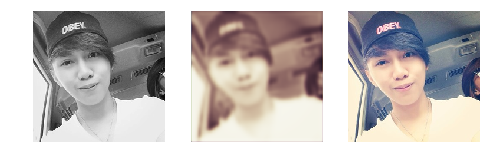

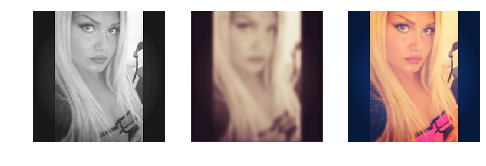

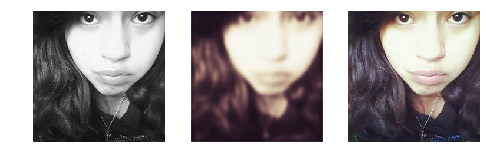

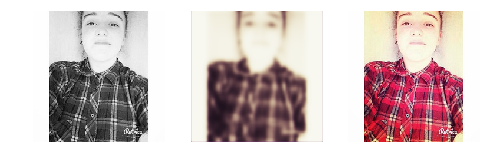

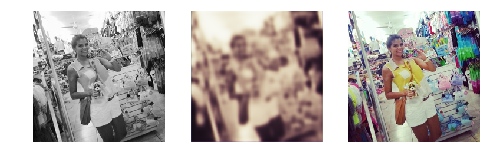

In [34]:
for id in range(8):
    fig = plt.figure(figsize=(8, 4))
    fig.add_subplot(1, 3, 1)
    plt.imshow(X[id], cmap='gray')
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(np.uint8(model.predict(X_scaled[id:id+1])[0]*255))
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(np.uint8(y_scaled[id]*255))
    plt.axis('off')
    plt.show()

In [20]:
model.save('coloRayzorAutoencode.h5')

## Troisième modèle
Reduction de dimension puis reshaping pour avoir une image 224,224,3

In [24]:
model = Sequential()
model.add(Conv2D(3, kernel_size=3, padding="same", input_shape=X_scaled.shape[1:], activation="sigmoid"))

model.add(Conv2D(16, kernel_size=3, padding="same", activation="sigmoid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Conv2D(32, kernel_size=3, padding="same", activation="sigmoid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Conv2D(64, kernel_size=3, padding="same", activation="sigmoid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Conv2D(128, kernel_size=3, padding="same", activation="sigmoid"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

model.add(Conv2D(768, kernel_size=3, padding="same", activation="sigmoid"))

model.add(Reshape((224,224,3)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 224, 224, 3)       30        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 64)        0         
__________

In [25]:
model.compile(
    optimizer='adam',
    loss='mse'
)

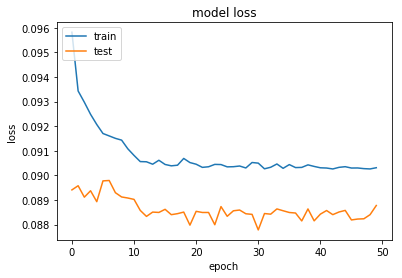

In [26]:
from IPython.core.display import HTML
from keras_tqdm import TQDMNotebookCallback

display(HTML("""
    <style>
        .p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
              padding: 0;
              border: 0;
        }
    </style>
"""))

history = model.fit(
    X_scaled,
    y_scaled,
    epochs=50,
    batch_size=5, 
    verbose=0,
    validation_split=0.2,
    shuffle=True,
    callbacks=[
        TQDMNotebookCallback()
    ]
)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

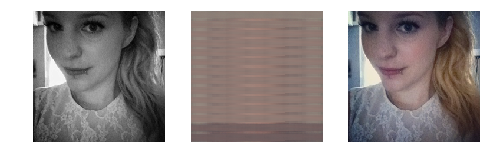

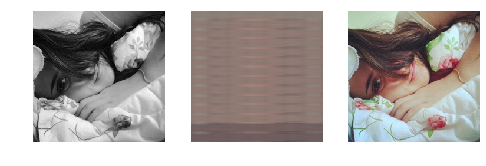

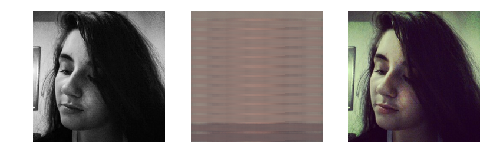

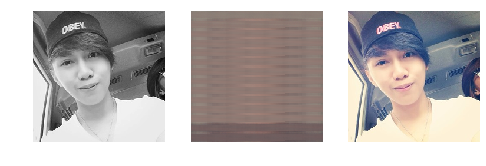

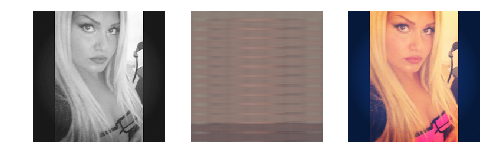

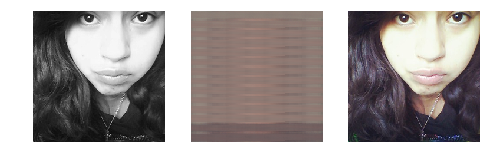

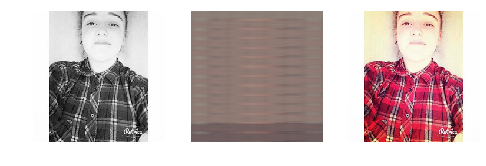

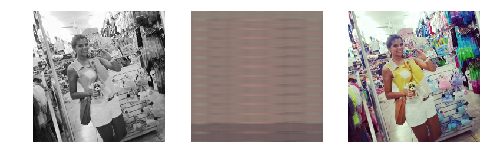

In [28]:
for id in range(8):
    fig = plt.figure(figsize=(8, 4))
    fig.add_subplot(1, 3, 1)
    plt.imshow(X[id], cmap='gray')
    plt.axis('off')
    fig.add_subplot(1, 3, 2)
    plt.imshow(np.uint8(model.predict(X_scaled[id:id+1])[0]*255))
    plt.axis('off')
    fig.add_subplot(1, 3, 3)
    plt.imshow(np.uint8(y_scaled[id]*255))
    plt.axis('off')
    plt.show()